# Transformer Model

基于Transformer架构的翻译模型训练一个问答模型，即：问题到答案的"翻译"。

## 数据集

cMedQA2：中文医学问答的数据集的2.0版本，数据是匿名的，不包括任何个人信息。

| DataSet | #Ques | #Ans | Ave. #words per Question |  Ave. #words per Answer| Ave. #characters per Question | Ave. #characters per Answer |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|Train|100,000|188,490|-|-|48|101|
|Dev|4,000|7,527|-|-|49|101|
|Test|4,000|7,552|-|-|49|100|
|Total|108,000|203,569|-|-|49|101|

* **questions.csv** ：全部的问题数据
* **answers.csv** ：全部的答案数据   
* **train_candidates.txt** 、 **test_candidates.txt** ：划分好的训练测试集

In [3]:
import os
import time
import jieba
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' 

### 数据预处理

In [4]:
question_df = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/question.csv')

answer_df = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/answer.csv')

#### 结巴分词

- wordslist : 以词为单位进行分词
- wordlist : 以字为单位进行分词

In [7]:
question_df['wordslist'] = question_df.content.apply(lambda x: list(jieba.cut(x)))

question_df['wordlist'] = question_df.content.apply(lambda x: list(x))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.751 seconds.
Prefix dict has been built successfully.


In [8]:
answer_df['wordslist'] = answer_df.content.apply(lambda x: list(jieba.cut(x)))

answer_df['wordlist'] = answer_df.content.apply(lambda x: list(x))

In [9]:
answer_df.head(3)

,ans_id,question_id,content,wordslist,wordlist
0,0,45619783,月经延迟十四天而且伴随恶心，头痛，乏力的现象，那么考虑怀孕的概率是非常大的，建议你去医院检查...,"[月经, 延迟, 十四天, 而且, 伴随, 恶心, ，, 头痛, ，, 乏力, 的, 现象,...","[月, 经, 延, 迟, 十, 四, 天, 而, 且, 伴, 随, 恶, 心, ，, 头, ..."
1,1,45619783,如果你的月经周期规律，有正常的性生活，未采取任何有效的避孕措施，此时的症状考虑有怀孕的可能。...,"[如果, 你, 的, 月经周期, 规律, ，, 有, 正常, 的, 性生活, ，, 未, 采...","[如, 果, 你, 的, 月, 经, 周, 期, 规, 律, ，, 有, 正, 常, 的, ..."
2,2,45619783,建议在性生活过后14天左右可以用怀孕试纸自我检测一下，一般怀孕试纸显示2条线的话是怀孕了的，...,"[建议, 在, 性生活, 过后, 14, 天, 左右, 可以, 用, 怀孕, 试纸, 自我,...","[建, 议, 在, 性, 生, 活, 过, 后, 1, 4, 天, 左, 右, 可, 以, ..."


#### 划分数据

- candidates.txt 里面划分的数据是一对多，一个问题有多个答案（消极、积极）

In [10]:
train_ids = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/train_candidates.txt')
test_ids = pd.read_csv('/home/wjh/DataSet/cMedQA2-master/test_candidates.txt')
test_ids = test_ids.drop_duplicates('question_id')
train_ids = train_ids.drop_duplicates('question_id')

In [14]:
train_data = train_ids.merge(question_df[['question_id','wordlist']], on='question_id', how='left')
train_data = train_data.merge(answer_df[['ans_id','wordlist']], left_on='pos_ans_id', right_on='ans_id')
test_data = test_ids.merge(question_df[['question_id','wordlist']], on='question_id', how='left')
test_data = test_data.merge(answer_df[['ans_id','wordlist']], on='ans_id', how='left')

In [15]:
test_data.head(3)

,question_id,ans_id,cnt,label,wordlist_x,wordlist_y
0,23423734,137315,0,1,"[我, 的, 右, 脚, 外, 踝, 骨, 折, 一, 年, 多, ・, 平, 时, 有, ...","[你, 的, 情, 况, 考, 虑, 局, 部, 有, 炎, 症, 的, 可, 能, 性, ..."
1,6469692,153600,0,1,"[全, 部, 症, 状, ：, 手, 指, 关, 节, 不, 小, 心, 韧, 带, 扭, ...","[首, 先, 建, 议, 拍, 片, 看, 看, 是, 否, 是, 有, 骨, 折, 啊, ..."
2,4833968,51452,0,1,"[请, 问, 一, 下, 脑, 袋, 疼, 的, 厉, 害, ，, 基, 本, 整, 个, ...","[如, 果, 你, 有, 这, 方, 面, 的, 烦, 恼, ，, 请, 先, 到, 正, ..."


把分词后的结果拼接为字符串，空格分隔：

In [18]:
train_qs = np.array([' '.join(wordlist) for wordlist in train_data.wordlist_x])
train_as = np.array([' '.join(wordlist) for wordlist in train_data.wordlist_y])

test_qs = np.array([' '.join(wordlist) for wordlist in test_data.wordlist_x])
test_as = np.array([' '.join(wordlist) for wordlist in test_data.wordlist_y])

#### Tokenize

分别对问题和答案的文本中的词汇进行标记，即：`words`$\to$`token`。token就是一个整数，代表一个词在词汇表中的索引。

给每个文本添加开始和结束标识符：`[START]`、`[END]`，这个没有固定格式可以自定义。

In [22]:
def add_start_end_token(text):
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

文本向量化，即转换为token序列：

In [34]:
question_vocab_size = 5000
question_max_length = 150     # 问题文本最大长度，不足补零

question_vectorization = tf.keras.layers.TextVectorization(
                                standardize = add_start_end_token,
                                max_tokens = question_vocab_size,
                                output_mode = 'int',
                                output_sequence_length = question_max_length)
# question vocabulary
question_vectorization.adapt(train_qs)

In [35]:
answer_vocab_size = 5000
answer_max_length = 250

answer_vectorization = tf.keras.layers.TextVectorization(
                                standardize = add_start_end_token,
                                max_tokens = answer_vocab_size,
                                output_mode = 'int',
                                output_sequence_length = answer_max_length)
# answer vocabulary
answer_vectorization.adapt(train_as)

words$\to$token，token$\to$words

In [37]:
print("question : ",train_qs[0])
print("\n")
example_tokens = question_vectorization(train_qs[0])
print("question tokens :", example_tokens)

question :  不 是 说 做 b 超 对 宝 宝 不 好 吗 ？ 那 怀 孕 检 查 是 不 ？ 不 是 说 做 b 超 对 宝 宝 不 好 吗 ？ 那 怀 孕 检 查 是 不 是 越 少 越 好 。 无 麻 烦 解 答 ， 谢 谢 。


question tokens : tf.Tensor(
[  3  12   5  94  50 578 213 216  34  34  12  27  19  11 214  39  22  56
  48   5  12  11  12   5  94  50 578 213 216  34  34  12  27  19  11 214
  39  22  56  48   5  12   5 442 195 442  27  10 110 150 632 258 487   2
 115 115  10   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0], shape=(150,), dtype=int64)


In [38]:
question_vocab = np.array(question_vectorization.get_vocabulary())
example_words = question_vocab[example_tokens.numpy()]
' '.join(example_words)

'[START] 不 是 说 做 b 超 对 宝 宝 不 好 吗 ？ 那 怀 孕 检 查 是 不 ？ 不 是 说 做 b 超 对 宝 宝 不 好 吗 ？ 那 怀 孕 检 查 是 不 是 越 少 越 好 。 无 麻 烦 解 答 ， 谢 谢 。 [END]                                                                                            '

#### 创建数据集

把数据转换为适合训练的格式：((question, answer_in),answer_out)

(question, answer_in)作为模型的输入，answer_out为模型的输出，也就是标签。answer_in 和 answer_out 之间的区别在于它们相对于彼此移动一个位置的索引，因此answer_out在每个位置的token都是answer_in的下一个的token。

这个叫做`teacher forcing`,即：模型在每个时间步的输出，都是通过上一个时间步真实值作为输入。这是训练文本生成模型的一种简单有效的方法。它非常高效，因为您不需要按顺序运行模型，可以并行计算不同序列位置的输出。

In [39]:
def prepare_batch(question, answer):
    question = question_vectorization(question)
    answer = answer_vectorization(answer)
    answer_in = answer[:,:-1]          # Drop the [END] tokens
    answer_out = answer[:,1:]          # Drop the [START] tokens
    return (question, answer_in), answer_out

In [40]:
BUFFER_SIZE = len(train_qs)
BATCH_SIZE = 64

train_ds = (tf.data.Dataset
              .from_tensor_slices((train_qs, train_as))
              .shuffle(BUFFER_SIZE)
              .batch(BATCH_SIZE)
              .map(prepare_batch, tf.data.AUTOTUNE)
              .prefetch(buffer_size= tf.data.AUTOTUNE))

In [41]:
test_ds = (tf.data.Dataset
             .from_tensor_slices((test_qs, test_as))
             .shuffle(len(test_qs))
             .batch(BATCH_SIZE)
             .map(prepare_batch, tf.data.AUTOTUNE)
             .prefetch(buffer_size=tf.data.AUTOTUNE))

In [42]:
for (question_toks, answer_in_toks), answer_out_toks in train_ds.take(1):
    break

print(question_toks.shape)
print(answer_in_toks.shape)
print(answer_out_toks.shape)

(64, 150)
(64, 249)
(64, 249)


In [43]:
print(question_toks[0][:10])
print(answer_in_toks[0][:10])
print(answer_out_toks[0][:10])

tf.Tensor([   3  123 1208   28  135  208   29    2  110   90], shape=(10,), dtype=int64)
tf.Tensor([   8  127   13  324   86 1374  265   42  256   90], shape=(10,), dtype=int64)
tf.Tensor([ 127   13  324   86 1374  265   42  256   90  221], shape=(10,), dtype=int64)


## 模块定义
- 嵌入层
- 注意力层
- 前馈层

### 位置嵌入

&emsp;&emsp;嵌入层就是一个查询表，把token转换为对应的向量。注意力层将词向量输入视为一组向量，没有顺序，它需要某种方法来识别词序，否则它会将输入序列视为一袋单词实例，无法区分：how are you 、how you are、you how are。所以将“位置编码”添加到嵌入向量。 根据定义，附近的元素将具有类似的位置编码，位置编码方式有很多，下面是正弦余弦编码。

位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / embed_{dim} })}$$

$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / embed_{dim} })}$$

In [44]:
def positional_encoding(length, embed_dim):
    embed_dim = embed_dim/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    embed_dims = np.arange(embed_dim)[np.newaxis, :]/embed_dim   # (1, embed_dim)

    angle_rates = 1 / (10000**embed_dims)                # (1, embed_dim)
    angle_rads = positions * angle_rates                 # (pos, embed_dim)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

可视化位置嵌入矩阵

(125, 128)


<Axes: >

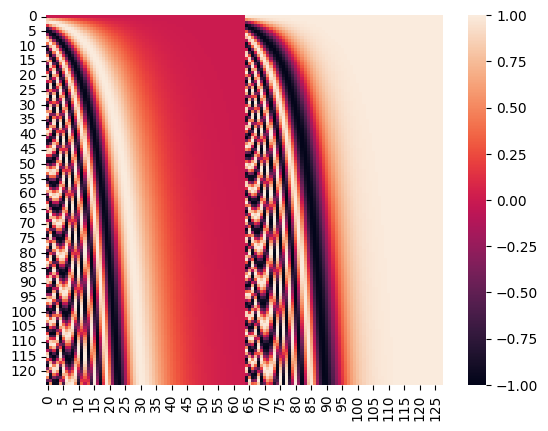

In [45]:
pos_encoding = positional_encoding(length=125, embed_dim=128)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
sns.heatmap(pos_encoding)

#### 嵌入层

words Embedding + position Embedding

In [46]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, seq_length=125, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        self.seq_length = seq_length
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True) 
        self.pos_encoding = positional_encoding(seq_length, embed_dim)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [47]:
q_vocab_size = len(question_vectorization.get_vocabulary())
a_vocab_size = len(answer_vectorization.get_vocabulary())
q_vocab_size, a_vocab_size

(4035, 4117)

In [48]:
question_toks[0]

<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([   3,  123, 1208,   28,  135,  208,   29,    2,  110,   90,  226,
          2,   14,  122,    7,    2,   32,   33,   27,  382,    4,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [49]:
question_embed = Embedding(vocab_size=q_vocab_size, seq_length=150, embed_dim=128)
answer_embed = Embedding(vocab_size=a_vocab_size, seq_length=250, embed_dim=128)

q_emb = question_embed(question_toks[:1])
a_emb = answer_embed(answer_in_toks[:1])

q_emb.shape, a_emb.shape

(TensorShape([1, 150, 128]), TensorShape([1, 249, 128]))

### 注意力机制

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$


*缩放点乘注意力实现*：

In [53]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k must have matching embed dimensions.
    k, v must have matching timestep dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    # Since mask is 1.0 for positions we want to keep and 0.0 for masked
    # positions, this operation will create a tensor which is 0.0 for
    # positions we want to attend and -1e.9 for masked positions.
    if mask is not None:
        scaled_attention_logits += (1.0 - mask) * -1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

缩放点乘注意力的本质是查询，查询`query`的最佳`value`，通过点乘计算`query`与每个`key`的近似程度，然后在加权求和得到`query`的`value`。下面通过一些例子演示注意力机制：

In [54]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

In [55]:
# q 与第二个 k 最匹配，返回缩放后的 v 的第二组 值
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

In [56]:
temp_out.numpy(), temp_attn.numpy()

(array([[1.000000e+01, 9.276602e-25]], dtype=float32),
 array([[8.433274e-26, 1.000000e+00, 8.433274e-26, 8.433274e-26]],
       dtype=float32))

从注意力的分数也可以看出`query`与`key`的接近程度，下面是一组查询：

In [61]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)


temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

In [62]:
temp_attn

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[4.216637e-26, 4.216637e-26, 5.000000e-01, 5.000000e-01],
       [8.433274e-26, 1.000000e+00, 8.433274e-26, 8.433274e-26],
       [5.000000e-01, 5.000000e-01, 4.216637e-26, 4.216637e-26]],
      dtype=float32)>

Text(0.5, 1.0, 'Attention Scores')

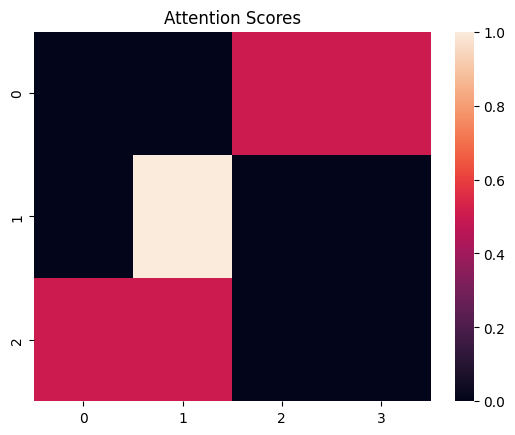

In [92]:
sns.heatmap(temp_attn.numpy())
plt.title("Attention Scores")

*注意力掩码：*

用来屏蔽部分注意力，例如屏蔽序列中填充值0、屏蔽下一个token。掩码屏蔽操作用在softmax之前，通过矩阵加法来实现：
1. mask : 1.:保留注意力，0.屏蔽注意力
2. 1-mask : 0.:保留注意力，1.:屏蔽注意力
3. 掩码屏蔽位置置为：-1e9,与缩放后的注意力相加
```python
if mask is not None:
      scaled_attention_logits += (1.0 - mask) * -1e9
```

下面是几种常见的掩码计算过程：

In [20]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.not_equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq#[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [65]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.]], dtype=float32)>

In [21]:
def create_causal_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [72]:
x = tf.random.uniform((1, 3))
temp = create_causal_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

### 其他注意力机制

在基础注意力的基础之上延伸出的其他注意力机制，不同的注意力集中应用在不同的编解码器中：

- 交叉注意力
- 全局注意力
- 因果注意力
- 多头注意力

下面基于Tensorflow提供的`MultiHeadAttention`,(Tensorflow:2.11支持causal_mask)实现其他注意力层：

In [50]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

交叉注意力层：

该层连接编码器和解码器,q : answer_in_embed, k : question_embed, v: question_embed

In [51]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x,
                                        key=context,
                                        value=context,
                                        return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [52]:
sample_ca = CrossAttention(num_heads=2, key_dim=128)

print(q_emb.shape)
print(a_emb.shape)
print(sample_ca(a_emb, q_emb).shape)

(1, 150, 128)
(1, 249, 128)
(1, 249, 128)


Text(0.5, 1.0, 'Attention Scores')

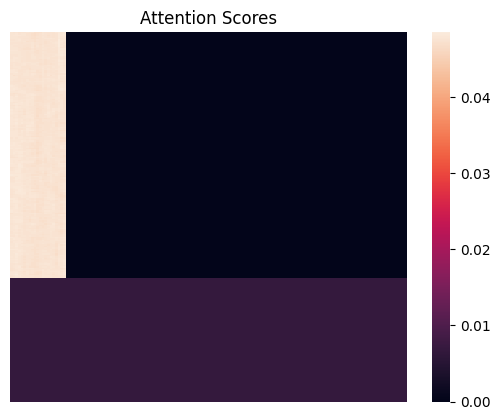

In [53]:
sns.heatmap(sample_ca.last_attn_scores[0][0].numpy())
plt.axis('off')
plt.title("Attention Scores")

全局自注意力层：

该层负责处理上下文序列（question)，由于在生成翻译时上下文序列是固定的，因此允许信息双向流动。在Transformer和Attention之前，模型通常使用RNN或CNN。

RNN和CNN的局限性：

- RNN允许信息在整个序列中一直流动，但它要经过许多处理步骤才能到达那里（限制梯度流）。这些 RNN 步骤必须按顺序运行，因此 RNN 不太能够利用现代并行设备。
- 在CNN中，每个位置都可以并行处理，但它只提供有限的感受野。感受野仅随CNN层的数量线性增长，您需要堆叠多个卷积层才能跨序列传输信息（Wavenet通过使用膨胀卷积来减少这个问题）。

全局自注意层允许序列的每个元素直接访问其他每个序列元素。

In [54]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [55]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=128)

print(q_emb.shape)
print(sample_gsa(q_emb).shape)

(1, 150, 128)
(1, 150, 128)


#### 因果自注意力层

此层与全局自注意层类似,不过用于解码器。

&emsp;&emsp;文本生成一个“自回归”模型：它们一次生成一个标记的文本，并将输出反馈给输入。为了提高效率，这些模型确保每个序列元素的输出仅依赖于先前的序列元素;这些模型是“因果关系”的。单向RNN也可以处理因果关系，只要进行因果卷积，`layers.Conv1D(padding='causal')`。因果自注意力层则通过掩码屏蔽来实现，上面全局自注意力层提到，序列中的每个元素可以直接“看到”序列中的其他元素，为了处理顺序的“因果”关系，通过掩码屏蔽部分注意力，确保每个位置的元素只能“看到”它之前位置的token。

In [56]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x,
                               use_causal_mask = True)   
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [57]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=128)

print(a_emb.shape)
print(sample_csa(a_emb).shape)

(1, 249, 128)
(1, 249, 128)


#### 前馈神经网络

由两个全连接层组成,先投射到高维在压缩到低维，采用ReLU激活函数，还有一个dropout层。与注意层一样，也包括残差连接和规范化。

In [58]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
                   tf.keras.layers.Dense(dff, activation='relu'),
                   tf.keras.layers.Dense(embed_dim),
                   tf.keras.layers.Dropout(dropout_rate)])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [59]:
sample_ffn = FeedForward(128, 2048)

print(a_emb.shape)
print(sample_ffn(a_emb).shape)

(1, 249, 128)
(1, 249, 128)


### 编码器

Embedding + Attention + FeedForward

- Embedding : WordsEmbedding + PositionEmbeding
- Attention : GlobalSelfAttention(x = q = k = v)

In [60]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, embed_dim, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(num_heads=num_heads,
                                                  key_dim=embed_dim,
                                                  dropout=dropout_rate)
        self.ffn = FeedForward(embed_dim, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

测试编码层,输入 queston的嵌入向量：

In [61]:
sample_encoder_layer = EncoderLayer(embed_dim=128, num_heads=8, dff=2048)

print(q_emb.shape)
print(sample_encoder_layer(q_emb).shape)

(1, 150, 128)
(1, 150, 128)


In [65]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, embed_dim, num_heads,seq_len,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.seq_length = seq_len

        self.pos_embedding = Embedding(vocab_size=vocab_size, seq_length=seq_len, embed_dim=embed_dim)

        self.enc_layers = [EncoderLayer(embed_dim=embed_dim,
                           num_heads=num_heads,
                           dff=dff,
                           dropout_rate=dropout_rate)
                           for _ in range(num_layers)]    # stack Encoder Layers
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, embed_dim)`.
        # Add dropout.
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x                  # Shape `(batch_size, seq_len, embed_dim)`.

测试编码器，输入question_toks：

In [66]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers = 4,
                         embed_dim = 128,
                         num_heads = 8,
                         seq_len=150,
                         dff = 2048,
                         vocab_size = q_vocab_size)

sample_encoder_output = sample_encoder(question_toks, training=False)

# Print the shape.
print(question_toks.shape)          # Shape (batch size, input_seq_len)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 150)
(64, 150, 128)


### 解码器

Embedding + Attention + FeedForward

- Embedding : WordsEmbedding + PositionEmbeding
- Attention : CausalSelfAttention + CrossAttention

In [67]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, embed_dim, num_heads,
                 dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads,
                                     key_dim=embed_dim,
                                     dropout=dropout_rate)

        self.cross_attention = CrossAttention(num_heads=num_heads,
                               key_dim=embed_dim,
                               dropout=dropout_rate)

        self.ffn = FeedForward(embed_dim, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
        # Shape `(batch_size, seq_len, d_model)`.
        x = self.ffn(x)   
        return x

测试解码层：

In [68]:
sample_decoder_layer = DecoderLayer(embed_dim=128, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(x=a_emb, context=q_emb)

print(a_emb.shape)
print(q_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(1, 249, 128)
(1, 150, 128)
(1, 249, 128)


In [70]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, embed_dim, num_heads, seq_len, dff, vocab_size,
                 dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.seq_lenght = seq_len

        self.pos_embedding = Embedding(vocab_size=vocab_size,
                                       seq_length=seq_len,
                                       embed_dim=embed_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(embed_dim = embed_dim, num_heads=num_heads,
                           dff=dff, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, embed_dim)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        # The shape of x is (batch_size, target_seq_len, embed_dim).
        return x

测试解码器：

In [72]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         embed_dim=128,
                         num_heads=8,
                         seq_len=250,
                         dff=1024,
                         vocab_size=a_vocab_size)

output = sample_decoder(x=answer_in_toks[:1], context=q_emb)

# Print the shapes.
print(answer_in_toks[:1].shape)
print(q_emb.shape)
print(output.shape)

(1, 249)
(1, 150, 128)
(1, 249, 128)


## Transformer

把编码器和解码器组合在一起，最后在添加全连接层，预测下一个token的概率分布。

In [77]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, embed_dim, num_heads, qseq_len, aseq_len, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, embed_dim=embed_dim,
                               num_heads=num_heads, dff=dff, seq_len=qseq_len,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, embed_dim=embed_dim,
                               num_heads=num_heads, dff=dff,seq_len=aseq_len,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x  = inputs                    # (question, answer_in)
        context = self.encoder(context)         # (batch_size, context_len, embed_dim)
        x = self.decoder(x, context)      # (batch_size, target_len, embed_dim)
        # Final linear layer output.
        logits = self.final_layer(x)      # (batch_size, target_len, target_vocab_size)
        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [78]:
# 参数
num_layers = 4
embed_dim = 256
dff = 1024
num_heads = 4
dropout_rate = 0.1

In [79]:
transformer = Transformer(num_layers=num_layers,
                          embed_dim=embed_dim,
                          num_heads=num_heads,
                          qseq_len=150,
                          aseq_len=250,
                          dff=dff,
                          input_vocab_size=q_vocab_size,  # 4035
                          target_vocab_size=a_vocab_size, # 4117
                          dropout_rate=dropout_rate)

In [81]:
output = transformer((question_toks, answer_in_toks))

print(question_toks.shape)
print(answer_in_toks.shape)
print(output.shape)

(64, 150)
(64, 249)
(64, 249, 4117)


In [82]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  7346944   
                                                                 
 decoder_2 (Decoder)         multiple                  11577600  
                                                                 
 dense_54 (Dense)            multiple                  1058069   
                                                                 
Total params: 19,982,613
Trainable params: 19,982,613
Non-trainable params: 0
_________________________________________________________________


### 训练模型

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

自定义学习率：

In [83]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()

        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

In [84]:
learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

可视化学习率变化曲线：

Text(0.5, 0, 'Train Step')

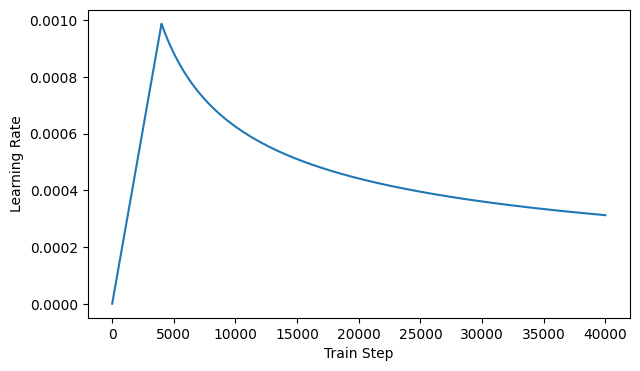

In [85]:
plt.figure(figsize=(7, 4))
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### 损失函数和目标函数

In [86]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Checkpints

In [87]:
checkpoint_path = "./checkpoints/TransformerQ2A-211"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [88]:
transformer.compile(loss=masked_loss,optimizer=optimizer,metrics=[masked_accuracy])

In [89]:
EPOCHS = 20

In [137]:
transformer.fit(train_ds,
                epochs=10,
                validation_data=test_ds, batch_size=128)

Epoch 1/10
 142/1563 [=>............................] - ETA: 6:46 - loss: 1.8793 - masked_accuracy: 0.5812

KeyboardInterrupt: 

### 模型推理

1. 对分词后的问题文本序列输入编码器，得到$q_{embed}$
2. 初始化预测输入`answer_in`:`[START]`
3. 计算`answer_in`的causal_mask
4. 把`(q_embed, answer_in)`到解码器，预测下一token的概率分布
5. 通过采用策略得到下一个token。
6. 把预测的token拼接到`answer_in`,作为新的输入，输入解码器
    - 如此这般，直到遇到结束符`[END]`或达到最大序列长度

In [94]:
class Translator(tf.Module):
    def __init__(self, transformer, question_processor, answer_processor):
        self.transformer = transformer
        self.question_processor = question_processor       # text string --> tokens 
        self.answer_processor = answer_processor
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=answer_processor.get_vocabulary(),
                                                       mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=answer_processor.get_vocabulary(),
                                                       mask_token='', oov_token='[UNK]',
                                                       invert=True)
        self.start_token = self.word_to_id(np.array('[START]',dtype=np.str_))
        self.end_token = self.word_to_id(np.array('[END]',dtype=np.str_))

    def __call__(self, qsentence, max_length=250):
        qsentence = tf.convert_to_tensor(qsentence)
        if len(qsentence.shape) == 0:
            qsentence = tf.convert_to_tensor(qsentence)[tf.newaxis]
        # adding the `[START]` and `[END]` tokens.
        qtokens = self.question_processor(qsentence)

        # initialize the output with the`[START]` token.
        start_end = self.answer_processor([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([qtokens, output],training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        outputs = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        words = self.id_to_word(outputs)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '\[START\]', '')
        result = tf.strings.regex_replace(result, '\[END\]', '')
        result = tf.strings.regex_replace(result, '\[UNK\]','')
        
        #text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.
        #tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([qtokens, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return result, attention_weights

In [115]:
# 预测结果后处理
def answer_postprocess(answer):
    answer = answer.numpy()[0].decode()
    words = answer.split(' ')
    return ''.join(words)

In [138]:
translator = Translator(transformer, question_processor=question_vectorization,
                        answer_processor=answer_vectorization)

测试模型

In [147]:
sample = test_data.sample(1) 
q_text = sample['wordlist_x'].values[0]
a_text = sample['wordlist_y'].values[0]
print("问题：",''.join(q_text))
q_text = ' '.join(q_text)
print("答案：",''.join(a_text))

问题： 皮肤瘙痒起红疙瘩小孩3。8岁每到夏天身上起红疙瘩，瘙痒一抓就起象风湿样一片，如何治疗？
答案： 看你说的这个症状，那看还是有过敏方面的原因引起的，这时也不排除是有患了荨麻疹的病情的，那像这种情况应该要对症用上抗过敏的药物治疗的好还有就是平时饮食方面要清淡些，不要吃刺激性大的食物，并且像海鲜类食物也应该要避免一下是会比较好的


In [148]:
result, attention_weights = translator(q_text)

answer_postprocess(result)

'这个情况考虑是因为过敏导致的，建议积极抗过敏治疗'

### 导出模型

In [149]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        result, attention_weights = self.translator(sentence)
        return result

In [150]:
translator = ExportTranslator(translator)

In [153]:
translator(q_text).numpy()[0].decode()

' 这 个 情 况 考 虑 是 因 为 过 敏 导 致 的 ， 建 议 积 极 抗 过 敏 治 疗 '

- 保存模型：tf.saved_model.save(translator, export_dir='TransformerQ2A')
- 加载模型：reloaded = tf.saved_model.load('translator')
    - `reloaded(question_text).numpy()[0].decode()`